# Car Insurance Customer Data Visualization



<i> We analyse  customer vehicle insurance data including demographics, education, employment, policy details, vehicle information, and claim amounts. We then report to the senior management.  The goal is to improve corporate services and  profitability. </i>

##### packages and boiler plate functions

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import norm
import math
%matplotlib inline
pd.options.display.max_rows = 100
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [17]:
def col_rename(df, dict_rules, ip=True):
    ''' rename columns in data frame using a dictionary of rules  '''
    if isinstance(df,pd.core.frame.DataFrame) and isinstance(dict_rules,dict):
        z = df.rename(columns = dict_rules, inplace=ip)
    else:
        raise TypeError
    return z
#
def print_unique(df,col):
    ''' gives a list of unique values in a field '''
    if isinstance(df,pd.core.frame.DataFrame) and isinstance(col,pd.core.frame.Series):
        z = df[col].unique()
    else:
        raise TypeError
    return z
#
def lower_case_column_names(df):
    ''' make columns lower case '''
    if isinstance(df,pd.core.frame.DataFrame):
        df.columns= [i.lower() for i in df.columns]
        df.columns = df.columns.str.replace(' ', '_')
    else: 
        raise TypeError
    return df
def strip_char(df,col,char):
    ''' strips a char and rounds '''
    return list(map(lambda x: round(float(x.strip(char))/100,2)\
                                          if type(x)==str else round((x/100),2),df[col]))
def record_str_replace(df, col, dict_rules):
    return df[col].replace(dict_rules) # additional replacement

In [18]:
def outlier_mask(df:pd.DataFrame, lower_b:float, upper_b:float) -> pd.DataFrame:
    """ produce a dataframe of true/false records corresponding to
    whether the record in the original df was inside/outside the iqr
    :param df: data we want to filter
    :param lower_b: lower quantile bound
    :param upper_b:  upper quantile bound
    :return: mask df of bools
    """
    print('generating outlier mask for columns:', list(df.columns))
    q1 = df.quantile(lower_b)
    q3 = df.quantile(upper_b)
    iqr = q3 - q1
    mask = ~((df < (q1 - 1.5*iqr))|(df > (q3 + 1.5*iqr)))
    return mask

##  Analysis
CONTENTS: 
  -  PDFs/Histograms
  -  Correlations
  -  Gaussianity determination
  -  Frequency counts and aggregations
  -  Pearson correlation heat map


### Read the data

In [19]:
c_df = pd.read_csv('Data/Data_Marketing_Customer_Analysis_Round3.csv').iloc[:,1:] # pre-conditioned data
c_df

,region,customer_lifetime_value,response,coverage,education,effective_to_date,month,employment_status,gender,income,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,central,4809,no,basic,college,2/18/11,feb,employed,m,48029,...,52,0,9,corporate auto,corporate l3,offer3,agent,292,four-door car,medsize
1,west region,2228,no,basic,college,1/18/11,jan,unemployed,f,26794,...,26,0,1,personal auto,personal l3,offer4,call center,744,four-door car,medsize
2,east,14947,no,basic,bachelor,2/10/11,feb,employed,m,22139,...,31,0,2,personal auto,personal l3,offer3,call center,480,suv,medsize
3,north west,22332,yes,extended,college,1/11/11,jan,employed,m,49078,...,3,0,2,corporate auto,corporate l3,offer2,branch,484,four-door car,medsize
4,north west,9025,no,premium,bachelor,1/17/11,jan,medical leave,f,23675,...,31,1,7,personal auto,personal l2,offer1,branch,707,four-door car,medsize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,central,15563,no,premium,bachelor,1/19/11,jan,unemployed,f,64811,...,40,2,7,personal auto,personal l1,offer3,web,1214,luxury car,medsize
10685,north west,5259,no,basic,college,1/6/11,jan,employed,f,61146,...,68,0,6,personal auto,personal l3,offer2,branch,273,four-door car,medsize
10686,central,23893,no,extended,bachelor,2/6/11,feb,employed,f,39837,...,63,0,2,corporate auto,corporate l3,offer1,web,381,luxury suv,medsize
10687,west region,11971,no,premium,college,2/13/11,feb,employed,f,64195,...,27,4,6,personal auto,personal l1,offer1,branch,618,suv,medsize


In [20]:
#c_df.drop(labels=['Unnamed: 0'],axis=1,inplace=True) # drop the unnamed field

In [21]:
numericals_df   = c_df.select_dtypes(include=np.number) # get numerical columns using the select_dtypes method
categoricals_df = c_df.select_dtypes(exclude=np.number)    # get cat columns

In [22]:
numericals_df.columns
categoricals_df.columns

Index(['customer_lifetime_value', 'income', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies',
       'total_claim_amount'],
      dtype='object')

Index(['region', 'response', 'coverage', 'education', 'effective_to_date',
       'month', 'employment_status', 'gender', 'location_code',
       'marital_status', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel', 'vehicle_class', 'vehicle_size'],
      dtype='object')

In [48]:
type(c_df['response'].iloc[0])

str

In [23]:
|type(c_df['response'].iloc[0])

str

In [24]:
cols_to_trim = list(numericals_df.drop(['total_claim_amount',
                                        'months_since_last_claim','months_since_policy_inception',
                                        'number_of_open_complaints', 'number_of_policies'],axis=1).columns)
# boolean index list of "inliers"
inliers = outlier_mask(numericals_df[cols_to_trim],0.15, 0.85).all(axis='columns')
# select subset of the data
numericals_df = numericals_df[inliers]
categoricals_df = categoricals_df[inliers]

generating outlier mask for columns: ['customer_lifetime_value', 'income', 'monthly_premium_auto']


In [25]:
c_df = pd.concat([categoricals_df, numericals_df],axis=1)

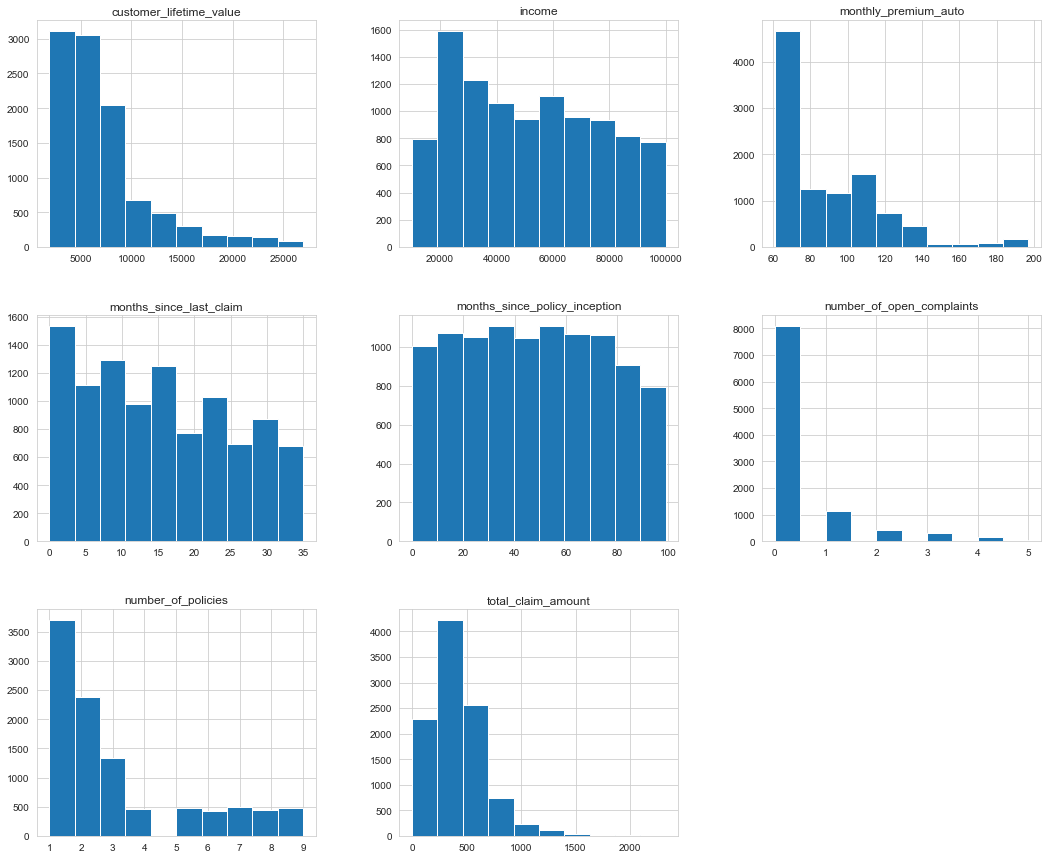

In [26]:
_=numericals_df.hist(figsize=(18,15)) # make histograms

In [27]:
c_df

,region,response,coverage,education,effective_to_date,month,employment_status,gender,location_code,marital_status,...,vehicle_class,vehicle_size,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,central,no,basic,college,2/18/11,feb,employed,m,suburban,married,...,four-door car,medsize,4809,48029,61,7,52,0,9,292
1,west region,no,basic,college,1/18/11,jan,unemployed,f,suburban,single,...,four-door car,medsize,2228,26794,64,3,26,0,1,744
2,east,no,basic,bachelor,2/10/11,feb,employed,m,suburban,single,...,suv,medsize,14947,22139,100,34,31,0,2,480
3,north west,yes,extended,college,1/11/11,jan,employed,m,suburban,single,...,four-door car,medsize,22332,49078,97,10,3,0,2,484
4,north west,no,premium,bachelor,1/17/11,jan,medical leave,f,suburban,married,...,four-door car,medsize,9025,23675,117,15,31,1,7,707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10682,central,no,basic,college,1/7/11,jan,employed,m,suburban,married,...,two-door car,medsize,2771,59855,74,30,82,4,1,355
10683,central,no,basic,high school or below,2/24/11,feb,unemployed,m,suburban,single,...,luxury suv,medsize,19228,56544,187,14,32,0,2,897
10685,north west,no,basic,college,1/6/11,jan,employed,f,urban,married,...,four-door car,medsize,5259,61146,65,7,68,0,6,273
10687,west region,no,premium,college,2/13/11,feb,employed,f,urban,divorced,...,suv,medsize,11971,64195,158,0,27,4,6,618


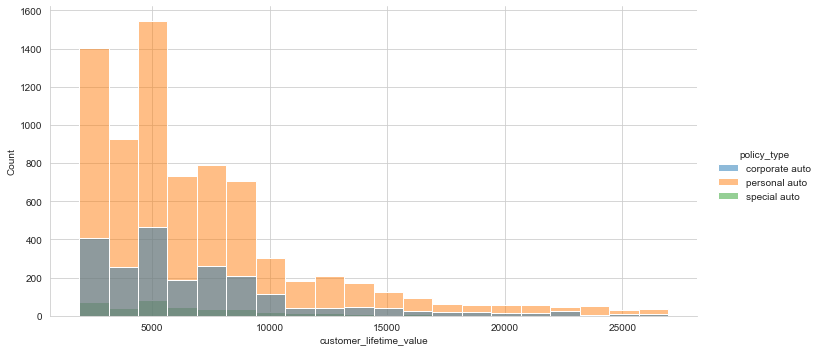

In [28]:
sns.displot(c_df, x="customer_lifetime_value", bins=20,aspect=2, hue='policy_type')

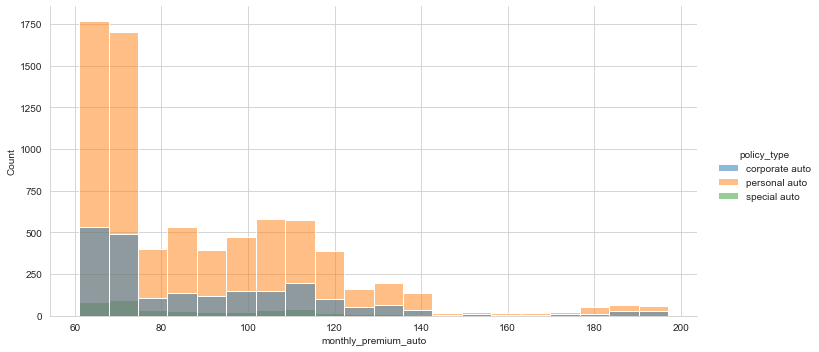

In [29]:
sns.displot(c_df, x="monthly_premium_auto", bins=20,aspect=2, hue='policy_type')

<i> the number_of_open_complaints and number_of_policies fields are discrete so we remove them below

In [30]:
n_data = [x for x in numericals_df.columns] # list of columns
n_data

['customer_lifetime_value',
 'income',
 'monthly_premium_auto',
 'months_since_last_claim',
 'months_since_policy_inception',
 'number_of_open_complaints',
 'number_of_policies',
 'total_claim_amount']

In [31]:
# remove the discrete fields
n_data.remove('number_of_open_complaints')
n_data.remove('number_of_policies')

#### Distributions

In [37]:
for i, j in zip(range(6), axes.flat):
    print(i,j)

0 AxesSubplot(0.125,0.536818;0.227941x0.343182)
1 AxesSubplot(0.398529,0.536818;0.227941x0.343182)
2 AxesSubplot(0.672059,0.536818;0.227941x0.343182)
3 AxesSubplot(0.125,0.125;0.227941x0.343182)
4 AxesSubplot(0.398529,0.125;0.227941x0.343182)
5 AxesSubplot(0.672059,0.125;0.227941x0.343182)


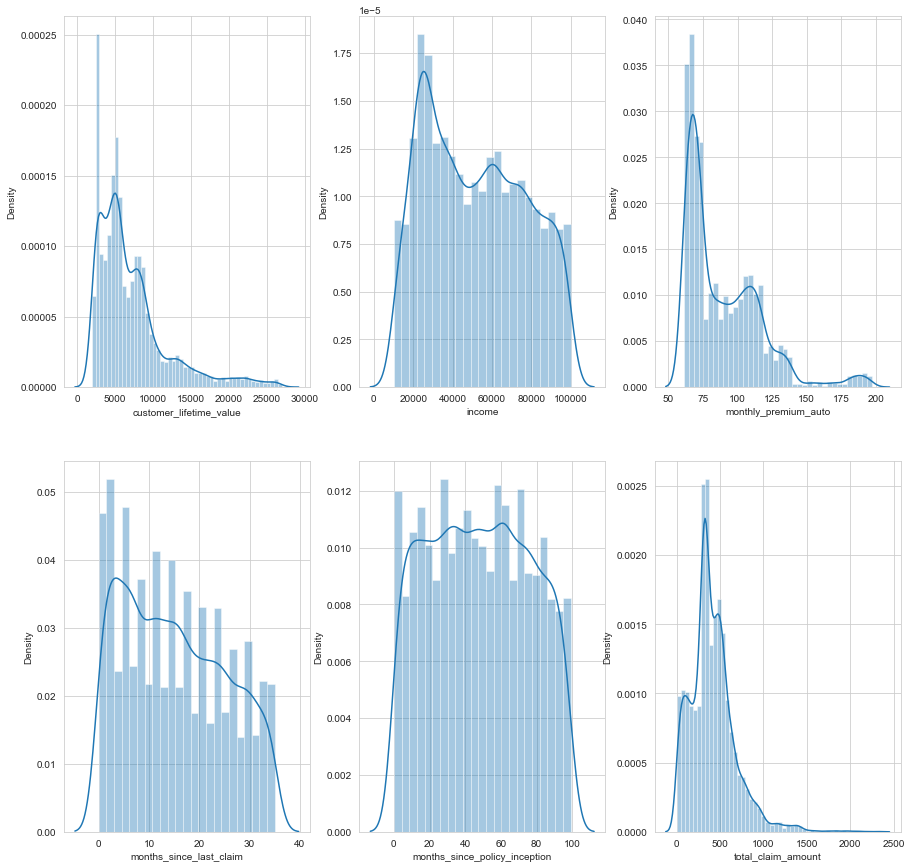

In [35]:
fig, axes = plt.subplots(ncols=3, nrows=2,figsize=(15,15))
# generate canvas of plots
for i, ax in zip(range(6), axes.flat):
    _=sns.distplot(c_df[n_data[i]], ax=ax,kde=True)
plt.show()

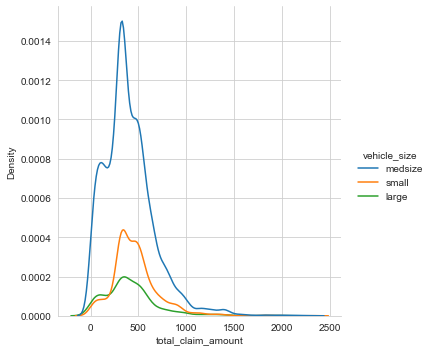

In [15]:
sns.displot(c_df, x="total_claim_amount", kind="kde",  hue="vehicle_size")

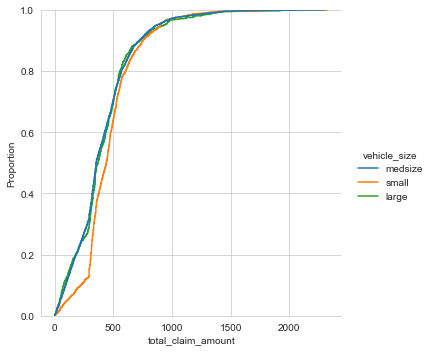

In [16]:
sns.displot(c_df, x="total_claim_amount", kind="ecdf", hue="vehicle_size") # cumulative distributions

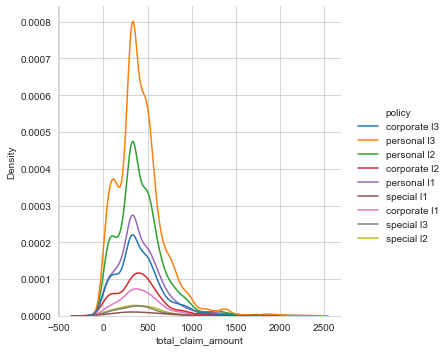

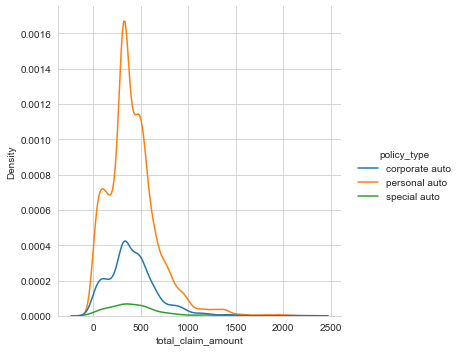

In [36]:
_=sns.displot(c_df, x="total_claim_amount", kind="kde", hue="policy")  # cumulative distributions
_=sns.displot(c_df, x="total_claim_amount", kind="kde", hue="policy_type")  # cumulative distributions

##### Fitting

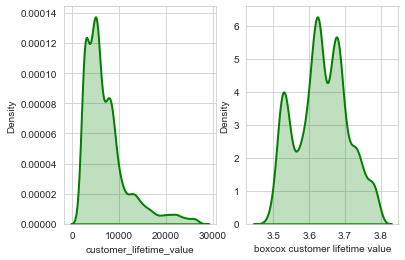

In [41]:
# transform training data & save lambda value
bc_customer_lifetime_value, _ = boxcox(numericals_df['customer_lifetime_value'])
 
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
 
# plotting the original data(non-normal) and
# fitted data (normal)
_ = sns.distplot(numericals_df['customer_lifetime_value'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])
 
_= sns.distplot(bc_customer_lifetime_value, hist = False, kde = True, axlabel='boxcox customer lifetime value',
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[1])

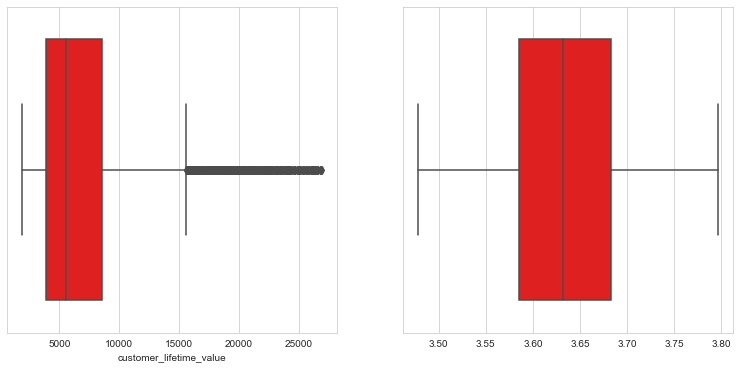

In [44]:
# creating axes to draw plots
fig, ax = plt.subplots(1, 2, figsize=(13,6))
_=sns.boxplot(numericals_df['customer_lifetime_value'], ax=ax[0], color='red')
_=sns.boxplot(bc_customer_lifetime_value, ax = ax[1], color='red')

In [43]:
corr_mat = numericals_df.corr()
corr_mat

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
customer_lifetime_value,1.000000,0.006767,0.319265,-0.000733,-0.008522,-0.032088,0.084082,0.148100
income,0.006767,1.000000,0.000869,-0.014154,0.013594,0.009198,-0.001380,-0.117442
monthly_premium_auto,0.319265,0.000869,1.000000,-0.005498,0.007216,-0.009183,-0.010024,0.555014
months_since_last_claim,-0.000733,-0.014154,-0.005498,1.000000,-0.043139,0.001943,0.004874,-0.008153
months_since_policy_inception,-0.008522,0.013594,0.007216,-0.043139,1.000000,0.006365,-0.007022,-0.010450
number_of_open_complaints,-0.032088,0.009198,-0.009183,0.001943,0.006365,1.000000,0.002691,-0.010717
number_of_policies,0.084082,-0.001380,-0.010024,0.004874,-0.007022,0.002691,1.000000,-0.000524
total_claim_amount,0.148100,-0.117442,0.555014,-0.008153,-0.010450,-0.010717,-0.000524,1.000000


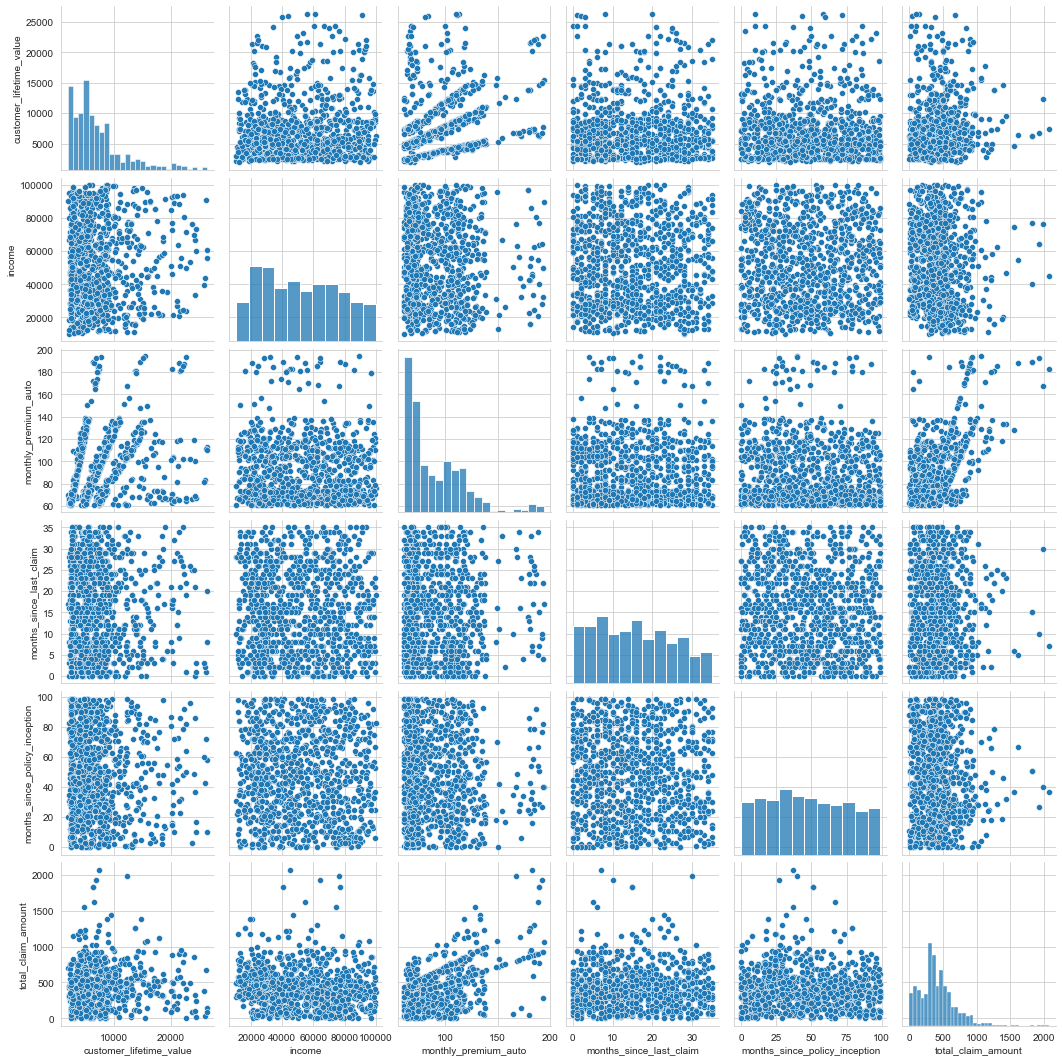

In [39]:
_=sns.pairplot(numericals_df.drop(columns=['number_of_open_complaints','number_of_policies']).sample(frac=.1))

w##### HEATMAP

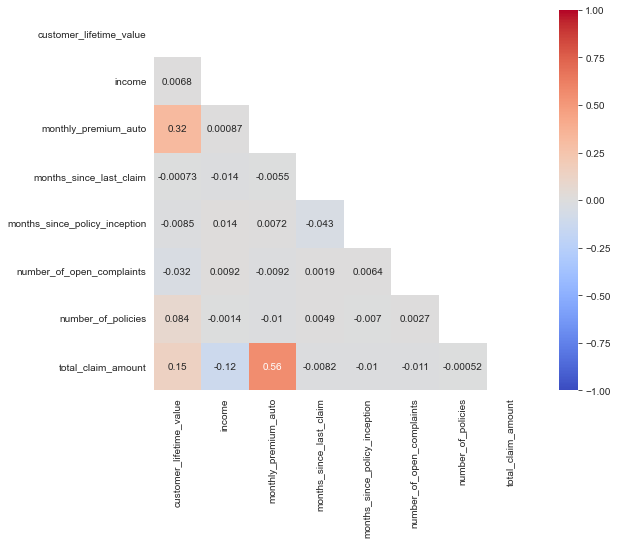

In [22]:
n_corr = numericals_df.corr()
corr_mask = np.zeros_like(n_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(n_corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

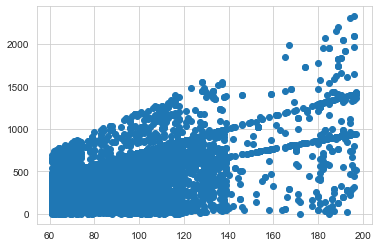

In [23]:
plt.scatter(x=numericals_df['monthly_premium_auto'], y=numericals_df['total_claim_amount'])
plt.show()

In [24]:
numericals_df['monthly_premium_auto']

0         61
1         64
2        100
3         97
4        117
        ... 
10682     74
10683    187
10685     65
10687    158
10688    101
Name: monthly_premium_auto, Length: 10215, dtype: int64

#### Observations
- Negligible multicolinearity in the data
- Modest correlation (r=approx .6) between total_claim_amount and monthly_premium_auto. Customer_lifetime_value is moderatedly correlated (r=.4) with monthly_premium_auto and total_claim_amount (r=.25) as well. The months_since_last_claim and monthly_premium_auto are expected to be anticorrelated, but this is not observed.


#### Highly Correlated Columns (absence of)

In [43]:
corr_thresh    =  0.9
corr_abs       = n_corr.abs()
upper_triangle = corr_abs.where(np.triu(np.ones(corr_abs.shape),k=1).astype(bool))
if len([column for column in upper_triangle.columns if any(upper_triangle[column] > corr_thresh)]) == 0:
    print("no correlated columns")

no correlated columns


### Categorical representations

<Figure size 1440x1080 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Coverage count by policy type')

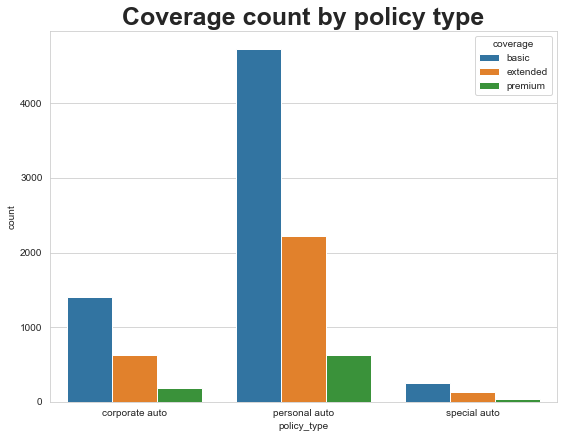

In [45]:
policy_cvg_counts_df = categoricals_df.groupby(['policy_type','coverage'])['policy'].count().rename('count').reset_index()
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.title('Coverage count by policy type', size='25', fontweight='bold')
_=sns.barplot(x = policy_cvg_counts_df['policy_type'],y = policy_cvg_counts_df['count'], hue = policy_cvg_counts_df['coverage'])

<AxesSubplot:xlabel='income'>

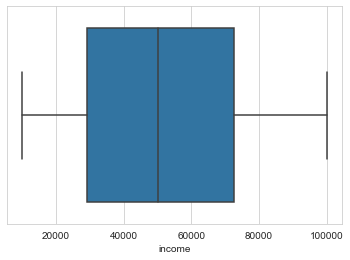

In [23]:
sns.boxplot(x="income",data=numericals_df)

### Customer responses 
**SUMMARY**
-  total number of responses (most customers don't respond)
-  response by the sales channel (Agent sales have highes number of responses)
-  response by the total claim amount (low claim amounts dominate)
-  response by income (middle incomes)


### Read and clean  

In [24]:
c2_df = pd.read_csv('Data/Data_Marketing_Customer_Analysis_Round2.csv')

In [25]:
c2_df.columns

Index(['Unnamed: 0', 'Customer', 'State', 'Customer Lifetime Value',
       'Response', 'Coverage', 'Education', 'Effective To Date',
       'EmploymentStatus', 'Gender', 'Income', 'Location Code',
       'Marital Status', 'Monthly Premium Auto', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Policy Type', 'Policy', 'Renew Offer Type',
       'Sales Channel', 'Total Claim Amount', 'Vehicle Class', 'Vehicle Size',
       'Vehicle Type'],
      dtype='object')

In [26]:
c2_df.drop(labels=['Unnamed: 0'],axis=1,inplace=True) # drop the unnamed field

In [27]:
lower_case_column_names(c2_df).head() # make headers uniformly lower case
c2_df.columns

Index(['customer', 'state', 'customer_lifetime_value', 'response', 'coverage',
       'education', 'effective_to_date', 'employmentstatus', 'gender',
       'income', 'location_code', 'marital_status', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies', 'policy_type',
       'policy', 'renew_offer_type', 'sales_channel', 'total_claim_amount',
       'vehicle_class', 'vehicle_size', 'vehicle_type'],
      dtype='object')

###  Overall responses 

Text(0, 0.5, 'count')

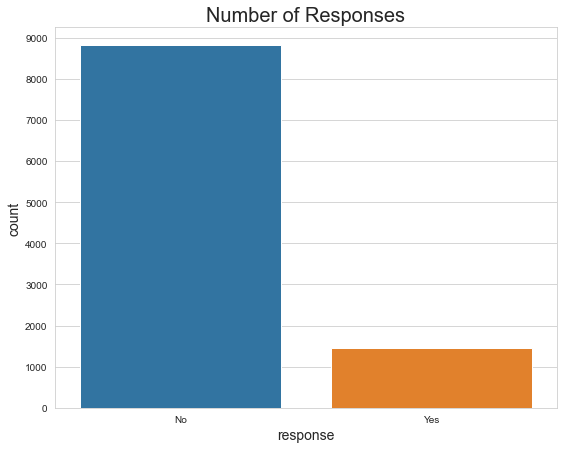

In [28]:
plt.figure(figsize=(9,7))
#plt.subplot(2,2,1)
plt.title('Number of Responses', size='20')
plt.yticks(np.arange(0,10000,1000))
sns.countplot(c2_df['response']) 
plt.xlabel('response',size=14)
plt.ylabel('count',size=14)

In [29]:
response_cnt = c2_df.groupby('sales_channel')['response'].value_counts()
type(response_cnt)

pandas.core.series.Series

In [30]:
response_cnt

sales_channel  response
Agent          No          3148
               Yes          742
Branch         No          2539
               Yes          326
Call Center    No          1792
               Yes          221
Web            No          1334
               Yes          177
Name: response, dtype: int64

In [31]:
#plt.figure(figsize=(12,10))
#plt.subplot(2,2,1)
#plt.title('Coverage count by policy type', size='25', fontweight='bold')
#sns.barplot(x = response_cnt['sales_channel'],y = response_cnt['count'], hue = response_cnt['response'])

### Responses for selected categories

#### Response by the sales channel

<AxesSubplot:title={'center':'Response by Sales Channel'}, xlabel='sales_channel', ylabel='count'>

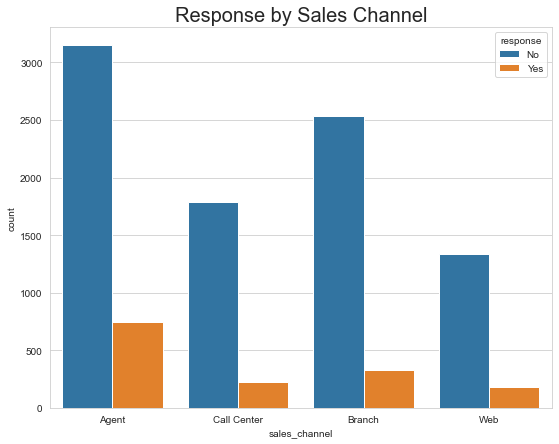

In [32]:
plt.figure(figsize=(9,7))
plt.title('Response by Sales Channel', size='20')

sns.countplot(x=c2_df['sales_channel'], hue=c2_df['response']) 

#### Response by the total claim amount

##### calculations 

In [33]:
max_claim = round(c2_df['total_claim_amount'].max())
inter = math.floor(max_claim/4)
quarts = [math.ceil(inter*i) for i in range(0,4)]
quarts

[0, 723, 1446, 2169]

In [34]:
chopped_claim_amounts = pd.cut(c2_df['total_claim_amount'],4,\
    labels=['c1:(0,723]','c2:(723,1447]','c3:(1447,2170])','c4:(2170,2893]'])

In [35]:
pd.cut(c2_df['total_claim_amount'],4) # split claims into 4 uniform bins

0          (-2.794, 723.384]
1        (723.384, 1446.669]
2          (-2.794, 723.384]
3          (-2.794, 723.384]
4          (-2.794, 723.384]
                ...         
10905    (723.384, 1446.669]
10906      (-2.794, 723.384]
10907      (-2.794, 723.384]
10908      (-2.794, 723.384]
10909    (723.384, 1446.669]
Name: total_claim_amount, Length: 10910, dtype: category
Categories (4, interval[float64, right]): [(-2.794, 723.384] < (723.384, 1446.669] < (1446.669, 2169.955] < (2169.955, 2893.24]]

In [36]:
#pd.qcut(c2_df['total_claim_amount'],[0, .25, .5, .75, 1.])

In [37]:
""" plt.figure(figsize=(9,7))
plt.title('Total claim amount by sales channel', size='20')
#plt.xlabel('quartiles of total sales [2893]' )
ax = sns.countplot(x=pd.qcut(c2_df['total_claim_amount'],[0, .25, .5, .75, 1.],labels=['q1','q2','q3','q4']), hue=c2_df['response']) 
ax.set_xlabel('quartiles of total sales [2893]') """

" plt.figure(figsize=(9,7))\nplt.title('Total claim amount by sales channel', size='20')\n#plt.xlabel('quartiles of total sales [2893]' )\nax = sns.countplot(x=pd.qcut(c2_df['total_claim_amount'],[0, .25, .5, .75, 1.],labels=['q1','q2','q3','q4']), hue=c2_df['response']) \nax.set_xlabel('quartiles of total sales [2893]') "

Text(0, 0.5, 'count')

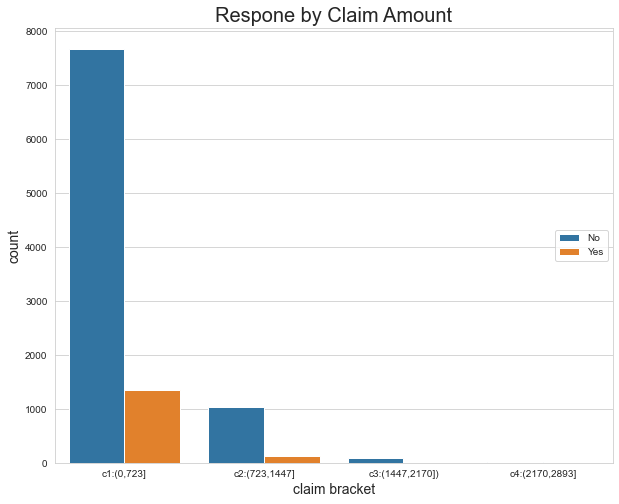

In [38]:
plt.figure(figsize=(10,8))
plt.title('Respone by Claim Amount', size='20')
#plt.xlabel('quartiles of total sales [2893]' )
ax = sns.countplot(x=chopped_claim_amounts, hue=c2_df['response']) 
ax.set_xlabel('claim bracket', size=14)
plt.legend(loc='right')
plt.ylabel('count',size=14)

The claims tend to be in the lowest bracket 

#### Response by income

##### calculations 

In [39]:
c2_df['income'].max()

99981

In [40]:
income_bins = [int(99981*x+.001) for x in [0,.25,.5,.75,1]]
bins = [0,25000,50000,75000,100000]
bins

[0, 25000, 50000, 75000, 100000]

In [41]:
income_cut = pd.cut(c2_df['income'],bins, labels=['<25k','25k to 50k','50k to 75k','75k to 100k'],\
                    duplicates='drop')#,include_lowest=True)

#####  results

Text(0, 0.5, 'count')

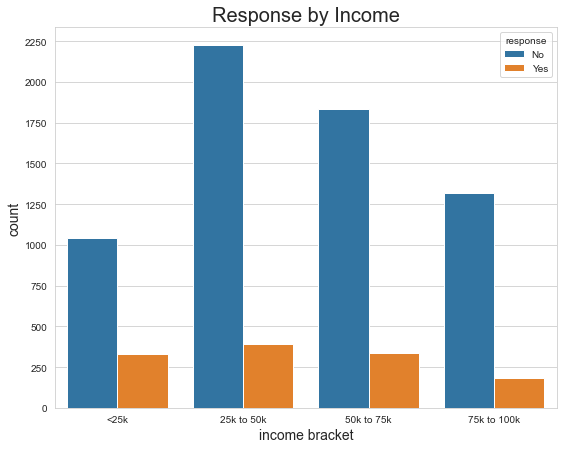

In [42]:
plt.figure(figsize=(9,7))
plt.title('Response by Income', size='20')
#plt.xlabel('quartiles of total sales [2893]' )
ax = sns.countplot(x=income_cut, hue=c2_df['response']) 
ax.set_xlabel('income bracket',size=14)
ax.set_yticks(np.arange(0,2500,250))
plt.ylabel('count',size=14)

The number of yes responses is **nearly uniform** across income brackets